In [1]:
import sys
sys.path += ["../"]

import smbh
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.special import erf

from astropy.cosmology import FlatLambdaCDM#LambdaCDM
COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Cosmology

In [2]:
cosmo = FlatLambdaCDM(H0 = 67.8, Om0 = 0.309)

In [3]:
SPEEDS = np.genfromtxt("../Week 13/initial.txt", delimiter = ', ', skip_header = 1)
AXIS = np.genfromtxt("../Week 13/axis.txt")

is_, a_1, a_2, a_3 = AXIS.T
js_, rv_x, rv_y, rv_z = SPEEDS.T

# Results

In [4]:
symmetric = np.genfromtxt("results.txt", skip_header = 1)

return_times = np.genfromtxt('../Week 13/return_times.txt')
return_masses = np.genfromtxt('../Week 13/return_masses.txt')
lyapunov = np.genfromtxt("../Week 13/lyapunov_exponents.txt")

# Global distributions

In [5]:
def gaussian(x, mu, std):
    v = std ** 2
    f = 1 / (2 * np.pi * v) ** 0.5
    exp = np.exp(- (x - mu) ** 2 / (2 * v))
    return f * exp

def gaussianInt(mu, std, a, b):
    v  = std ** 2
    e1 = erf((mu - a) / (2 * v) ** 0.5)
    e2 = erf((mu - b) / (2 * v) ** 0.5)
    return 0.5 * (e1 - e2)

def timeDist(x, mu1, std1, mu2, std2, a, b):
    return a * gaussian(np.log10(x), mu1, std1) + b * gaussian(np.log10(x), mu2, std2)

# def timeDist(x, mu1, std1):
#     return gaussian(np.log10(x), mu1, std1) / x

# def timeInt(mu1, std1, mu2, std2, a, b, c, d):
#     i1 = a * gaussianInt(mu1, std1, np.log10(c), np.log10(d))
#     i2 = b * gaussianInt(mu2, std2, np.log10(c), np.log10(d))
#     return i1 + i2

def plotHistogram(data, log = False, int_ = None, bins = None, density = True, ax = None, figsize = (8, 4.5),*args, **kwargs):
    if ax == None:
        fig, ax = plt.subplots(figsize = figsize)
    if bins == None:
        bins = int(np.ceil(len(data) ** 0.5))
    if log:
        freq, bins = np.histogram(np.log10(data), bins = bins, density = density)
        bins = 10 ** bins
        db = np.diff(bins)
        bins = 0.5 * (bins[1:] + bins[:-1])
        freq = freq / np.trapz(freq, np.log10(bins))
    else:
        freq, bins = np.histogram(data, bins = bins, density = density)
        db = np.diff(bins)
        bins = 0.5 * (bins[1:] + bins[:-1])
        freq = freq / np.trapz(freq, bins)

    if int_ != None:
        freq = freq / int_
        
    ax.bar(bins, freq, width = db, *args, **kwargs)
#     ax.plot(bins, freq)
    return ax, (bins, freq)

## Masses

In [6]:
masses = return_masses.flatten()

m_mu_t = masses.mean()
m_std_t = masses.std()

m_mu_s = symmetric[:, 1].mean()
m_std_s = symmetric[:, 1].std()

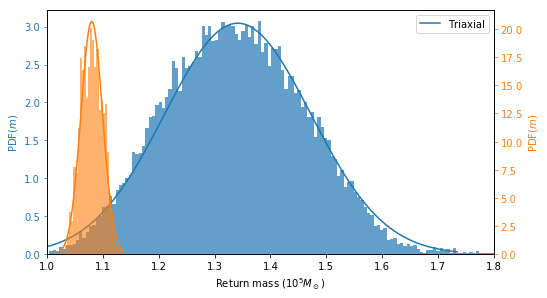

In [7]:
x1 = 3 * np.linspace(-1, 1, 100) * m_std_t + m_mu_t
x2 = 3 * np.linspace(-1, 1, 100) * m_std_s + m_mu_s

y1 = gaussian(x1, m_mu_t, m_std_t)
y2 = gaussian(x2, m_mu_s, m_std_s)

fig, ax1 = plt.subplots(figsize = (8, 4.5))

ax2 = ax1.twinx()

plotHistogram(masses, ax = ax1, alpha = 0.7)
ax1.plot(x1, y1)

plotHistogram(symmetric[:, 1], ax = ax2, alpha = 0.6, facecolor = COLOR_CYCLE[1])
ax2.plot(x2, y2, c = COLOR_CYCLE[1])

ax1.set_xlabel('Return mass ($10 ^ 5M_\odot$)')
ax1.set_ylabel(r'PDF$(m)$', color = COLOR_CYCLE[0])
ax1.tick_params('y', colors = COLOR_CYCLE[0])
ax2.set_ylabel(r'PDF$(m)$', color = COLOR_CYCLE[1])
ax2.tick_params('y', colors = COLOR_CYCLE[1])

ax1.set_xlim(1, 1.8)

ax1.legend(['Triaxial'])
# ax2.legend(['Spherical'])

fig.savefig('dist_masses.png', dpi = 300)

plt.show()

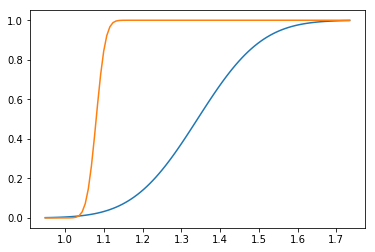

In [8]:
c_t = gaussianInt(m_mu_t, m_std_t, 0, x1)
c_s = gaussianInt(m_mu_s, m_std_s, 0, x1)
plt.plot(x1, c_t)
plt.plot(x1, c_s)

## Times

In [9]:
times = return_times.flatten()
pos = times != times.max()

times = 1000 * times[pos]

_, (t_bins_t, t_freq_t) = plotHistogram(times, log = True)
plt.close()
_, (t_bins_s, t_freq_s) = plotHistogram(1000 * symmetric[:, 0], log = True)
plt.close()

popt_t, pcov = curve_fit(timeDist, t_bins_t, t_freq_t, bounds = (([-np.inf, 0, -np.inf, 0] + [0] * 2), ([np.inf] * 4 + [1] * 2)))
popt_s, pcov = curve_fit(timeDist, t_bins_s, t_freq_s, bounds = (([-np.inf, 0, -np.inf, 0] + [0] * 2), ([np.inf] * 4 + [1] * 2)))

x = np.logspace(0, 6, 500)
# x = np.linspace(0, 1e6)
y_t = timeDist(x, *popt_t)
y_s = timeDist(x, *popt_s)

int_t = np.trapz(y_t, x = x)
int_s = np.trapz(y_s, x = x)
popt_t[-2:] *= 1 / int_t
popt_s[-2:] *= 1 / int_s

y_t = y_t / int_t
y_s = y_s / int_s

t_mu1_t, t_std1_t, t_mu2_t, t_std2_t, t_a_t, t_b_t = popt_t
t_mu1_s, t_std1_s, t_mu2_s, t_std2_s, t_a_s, t_b_s = popt_s

In [10]:
txt = r"""\hline
& \textbf{Spherical} & \textbf{Triaxial} \\
\hline"""
print(txt)

labels = ['$\mu_1$ $\log$(Myr)', '$\sigma_1$ $\log$(Myr)',
         '$\mu_2$ $\log$(Myr)', '$\sigma_1$ $\log$(Myr)',
         '$a$', '$b$']

for i in range(len(popt_t)):
    txt = r'%s & %f & %f\\' % (labels[i], popt_s[i], popt_t[i])
    print(txt)
print(r'\hline')

\hline
& \textbf{Spherical} & \textbf{Triaxial} \\
\hline
$\mu_1$ $\log$(Myr) & 2.224233 & 2.601585\\
$\sigma_1$ $\log$(Myr) & 0.812611 & 0.644694\\
$\mu_2$ $\log$(Myr) & 1.360731 & 1.806201\\
$\sigma_1$ $\log$(Myr) & 0.270754 & 0.230738\\
$a$ & 0.000448 & 0.000354\\
$b$ & 0.000115 & 0.000117\\
\hline


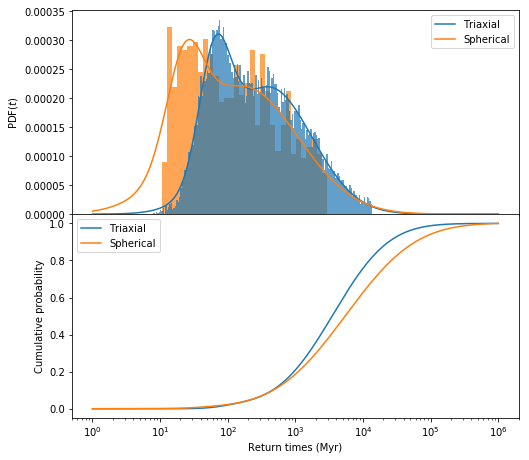

In [11]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (8, 7.5), sharex = True)

plotHistogram(1000 * symmetric[:, 0], log = True, int_ = int_s, ax = ax1, alpha = 0.7, facecolor = COLOR_CYCLE[1])
plotHistogram(times, log = True, int_ = int_t, ax = ax1, alpha = 0.7, facecolor = COLOR_CYCLE[0])

ax1.plot(x, y_t, c = COLOR_CYCLE[0], label = 'Triaxial')
ax1.plot(x, y_s, c = COLOR_CYCLE[1], label = 'Spherical')

ax1.set_ylabel(r'PDF$(t)$')

ax2.set_xlabel(r'Return times (Myr)')
ax2.set_ylabel(r'Cumulative probability')

ax1.legend()

cumulative_t = [np.trapz(y_t[: i + 1], x = x[: i + 1]) for i in range(len(y_t))]
ax2.plot(x, cumulative_t, label = 'Triaxial')

cumulative_s = [np.trapz(y_s[: i + 1], x = x[: i + 1]) for i in range(len(y_s))]
ax2.plot(x, cumulative_s, label = 'Spherical')

ax1.set_xscale("log")
ax2.legend()

fig.subplots_adjust(hspace = 0)

# fig.tight_layout()
fig.savefig('dist_times.png', dpi = 300)
plt.show()

# Relative properties:

In [12]:
r_t = return_times / symmetric[:, 0]
r_m = return_masses / symmetric[:, 1]
v = (rv_x ** 2 + rv_y ** 2 + rv_z ** 2) ** 0.5

In [13]:
T = (1 - (a_2 / a_1) ** 2) / (1 - (a_3 / a_1) ** 2)
pos = T.argsort()

In [14]:
colors = smbh.rgbToHex(smbh.getColors(len(T)))

color_m = np.zeros_like(return_times).astype(str)
vv = np.zeros_like(return_times)

for i, p in enumerate(pos):
    color_m[p, :] = colors[i]
    vv[p, :] = v

ts = r_t.flatten()
ms = r_m.flatten()
colors = color_m.flatten()
vv = vv.flatten()

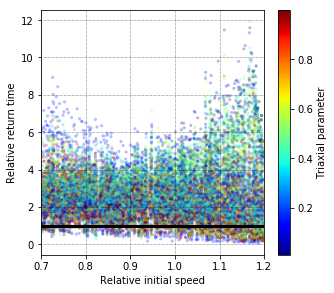

In [15]:
fig, ax = plt.subplots(figsize = (5, 4.5))

ax.scatter(vv, ts, color = colors, alpha = 0.2, s = 5)

ax.plot([0.7, 1.2], [1, 1], c = 'k', lw = 3)
    
sm = plt.cm.ScalarMappable(cmap = 'jet', norm = plt.Normalize(vmin = T.min(), vmax = T.max()))
sm._A = []
cb = fig.colorbar(sm)
cb.set_label('Triaxial parameter')

ax.set_xlim(0.7, 1.2)

ax.set_xlabel('Relative initial speed')
ax.set_ylabel('Relative return time')

ax.grid()

fig.savefig('relative_times.png', dpi = 300)

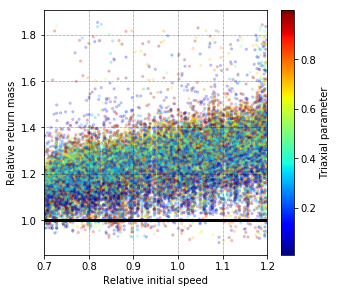

In [16]:
fig, ax = plt.subplots(figsize = (5, 4.5))

ax.scatter(vv, ms, color = colors, alpha = 0.2, s = 5)
ax.plot([0.7, 1.2], [1, 1], c = 'k', lw = 3)

sm = plt.cm.ScalarMappable(cmap = 'jet', norm = plt.Normalize(vmin = T.min(), vmax = T.max()))
sm._A = []
cb = fig.colorbar(sm)
cb.set_label('Triaxial parameter')

ax.set_xlim(0.7, 1.2)

ax.set_xlabel('Relative initial speed')
ax.set_ylabel('Relative return mass')

ax.grid()

fig.savefig('relative_mass.png', dpi = 300)

# Masses at:

In [18]:
t_20 = cosmo.age(20)
t_7 = cosmo.age(7.54)

In [21]:
t_7 - t_20

<Quantity 0.51290652 Gyr>

In [22]:
180 + 512

692